In [1]:
import sys
import os
sys.path.append(os.path.join(os.path.abspath(''), '../mermaid'))

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision
import sys
import os
import matplotlib.pyplot as plt
import mermaid.module_parameters as pars
import mermaid.model_factory as py_mf
import mermaid.utils as py_utils
import mermaid.similarity_measure_factory as smf
from mermaid.data_wrapper import AdaptVal
import mermaid.image_sampling as py_is
import mermaid.example_generation as eg
ds = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST("./files/",
        transform=torchvision.transforms.ToTensor()
        , download=True
    ),
    batch_size=500
)
import numpy as np
images = []
for _, batch in enumerate(ds):
    label = np.array(batch[1])
    batch_nines = label==3
    images.append(np.array(batch[0])[batch_nines])
images = np.concatenate(images)

ds = torch.utils.data.TensorDataset(torch.Tensor(images))
d1, d2 = (torch.utils.data.DataLoader(ds, batch_size=128, shuffle=True, ) for _ in (1,1))



Processing...
Done!


In [3]:
import matplotlib.pyplot as plt

In [13]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
class RegisNet(nn.Module):
    def __init__(self):
        super(RegisNet, self).__init__()
        self.conv1 = nn.Conv2d(2, 10, kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(12, 10, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(22, 10, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(32, 10, kernel_size=5, padding=2)
        self.conv5 = nn.Conv2d(42, 10, kernel_size=5, padding=2)
        self.conv6 = nn.Conv2d(52, 4, kernel_size=5, padding=2)

    def forward(self, x, y):
        x= torch.cat([x, y], 1)
        
        x = torch.cat([x, F.relu(self.conv1(x))], 1)
        x = torch.cat([x, F.relu(self.conv2(x))], 1)
        x = torch.cat([x, F.relu(self.conv3(x))], 1)
        x = torch.cat([x, F.relu(self.conv4(x))], 1)
        x = torch.cat([x, F.relu(self.conv5(x))], 1)
        x = self.conv6(x)
        return x[:, :2], x[:, 2:] - 6


class MermaidNet(nn.Module):
    def __init__(self):
        super(MermaidNet, self).__init__()       
        parameters = pars.ParameterDict()
        parameters.load_JSON("mermaid_config2.json")
        self.sz = np.array([128, 1, 28, 28])
        self.spacing = 1./(self.sz[2::]-1) 
        mf = py_mf.ModelFactory(self.sz, self.spacing, self.sz, self.spacing)
        net, loss = mf.create_registration_model(
            'lddmm_shooting_map', parameters["model"])
        net.computer_inverse_map = True
        loss.add_similarity_measure("ssd", smf.SSDSimilarity)

        _id = py_utils.identity_map_multiN(self.sz, self.spacing)
        self.identityMap = torch.from_numpy(_id).cuda()
        self.mermaid_unit = net.cuda()
        self.mermaid_loss = loss
        
        self.regis_net = RegisNet().cuda()
        
        self.sample = True
        

    def forward(self, moving_image, fixed_image):
        
        #modify self.mermaid_unit.m here
        mu, log_Sigma = self.regis_net(moving_image, fixed_image)
        
        reparam_trick_normal = torch.randn(
            mu.size(), 
            device=torch.device("cuda"))
        
        self.mu = mu
        self.log_Sigma = log_Sigma
        
        Sigma = torch.exp(log_Sigma)
        if self.sample:
            m = mu + Sigma * reparam_trick_normal
        else:
            print("didn't sample")
            m = mu
        self.mermaid_unit.m = m
        self.mermaid_loss.m = m
        
        #this call modifies self.phi
        self.warped_moving_image = self.__mermaid_shoot__(moving_image)
        
        all_loss, sim_loss, reg_loss = self.mermaid_loss(
            self.identityMap, 
            self.phi,
            moving_image,
            fixed_image,
            None,
            variables_from_forward_model=self.mermaid_unit.get_variables_to_transfer_to_loss_function(),
            variables_from_optimizer=None
        )
        KL_loss = -torch.sum(log_Sigma) + .05 * torch.sum(Sigma)
        print(KL_loss, all_loss)
        self.loss_dict = {
            'KL_Loss': KL_loss / self.sz[0],
            'all_loss': (all_loss + .001 * KL_loss) / self.sz[0],
            'sim_loss': sim_loss / self.sz[0],
            'reg_loss': reg_loss / self.sz[0]
        }
        

    def __mermaid_shoot__(self, moving_image):
        self.phi=self.mermaid_unit(self.identityMap, moving_image)
        warped_moving_image = py_utils.compute_warped_image_multiNC(/
            moving_image, 
            self.phi,
            self.spacing,
            spline_order=1
        )
        return warped_moving_image



net = MermaidNet()
0

Loading parameter file = mermaid_config2.json
Overwriting key = type; category = root.model.registration_model; value =  lddmm_shooting_map -> lddmm_shooting_map
Using map-based lddmm_shooting_map model
Using default value = 0.0 for key = tFrom of category = root.model.registration_model.forward_model
Creating new category: root.model.registration_model.forward_modelF
Using default value = 1.0 for key = tTo of category = root.model.registration_model.forward_modelF
Using default value = True for key = use_CFL_clamping of category = root.model.registration_model
Using default value = False for key = use_ode_tuple of category = root.model.registration_model.env
the param of smoother is <mermaid.smoother_factory.MultiGaussianFourierSmoother object at 0x7f2f446ecd50>
Creating new category: root.model.registration_model.loss
Using default value = False for key = display_max_displacement of category = root.model.registration_model.loss
Using default value = False for key = limit_displacement

0

In [14]:
optimizer = torch.optim.Adam(net.parameters(), lr=.0001)

In [15]:
net.train()

MermaidNet(
  (mermaid_unit): LDDMMShootingVectorMomentumMapNet(
    (integrator): ODEWrapBlock()
  )
  (mermaid_loss): LDDMMShootingVectorMomentumMapLoss()
  (regis_net): RegisNet(
    (conv1): Conv2d(2, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv2): Conv2d(12, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv3): Conv2d(22, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv4): Conv2d(32, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv5): Conv2d(42, 10, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (conv6): Conv2d(52, 4, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
)

In [16]:
for _ in range(40):
    for moving, fixed in list(zip(d1, d2)):
        if moving[0].size()[0] == 128:
            moving_image = moving[0].cuda()
            fixed_image = fixed[0].cuda()
            optimizer.zero_grad()
            net(moving_image, fixed_image)
            loss = net.loss_dict["all_loss"]
            print(loss.cpu().detach().numpy())
            loss.backward()
            optimizer.step()


Using default value = 1.0 for key = tTo of category = root.model.registration_model.forward_model


/media/data/hastings/2d-registration/notebook/../mermaid/mermaid/torchdiffeq/_impl/misc.py:81: UserWarning: Dopri5Solver: Unexpected arguments {'step_size': 0.1}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))


Creating new category: root.model.registration_model.similarity_measure
Using default value = ssd for key = type of category = root.model.registration_model.similarity_measure
Using ssd similarity measure
Using default value = 0.1 for key = sigma of category = root.model.registration_model.similarity_measure
tensor(1199635.5000, device='cuda:0', grad_fn=<AddBackward0>) tensor(2031.0253, device='cuda:0', grad_fn=<AddBackward0>)
25.239536
tensor(1198554.5000, device='cuda:0', grad_fn=<AddBackward0>) tensor(1878.0918, device='cuda:0', grad_fn=<AddBackward0>)
24.0363
tensor(1197312.7500, device='cuda:0', grad_fn=<AddBackward0>) tensor(1749.9604, device='cuda:0', grad_fn=<AddBackward0>)
23.025574
tensor(1196254.7500, device='cuda:0', grad_fn=<AddBackward0>) tensor(1543.7625, device='cuda:0', grad_fn=<AddBackward0>)
21.406384
tensor(1195196.7500, device='cuda:0', grad_fn=<AddBackward0>) tensor(1469.0536, device='cuda:0', grad_fn=<AddBackward0>)
20.814457
tensor(1193954.2500, device='cuda:0',

tensor(1117222.7500, device='cuda:0', grad_fn=<AddBackward0>) tensor(1174.3817, device='cuda:0', grad_fn=<AddBackward0>)
17.90316
tensor(1115715.6250, device='cuda:0', grad_fn=<AddBackward0>) tensor(1133.9968, device='cuda:0', grad_fn=<AddBackward0>)
17.575878
tensor(1113258.1250, device='cuda:0', grad_fn=<AddBackward0>) tensor(1081.4443, device='cuda:0', grad_fn=<AddBackward0>)
17.146114
tensor(1110955.2500, device='cuda:0', grad_fn=<AddBackward0>) tensor(1016.5266, device='cuda:0', grad_fn=<AddBackward0>)
16.620953
tensor(1108721.7500, device='cuda:0', grad_fn=<AddBackward0>) tensor(1064.2410, device='cuda:0', grad_fn=<AddBackward0>)
16.976273
tensor(1107414.2500, device='cuda:0', grad_fn=<AddBackward0>) tensor(1039.9847, device='cuda:0', grad_fn=<AddBackward0>)
16.776554
tensor(1105141.5000, device='cuda:0', grad_fn=<AddBackward0>) tensor(1044.1333, device='cuda:0', grad_fn=<AddBackward0>)
16.79121
tensor(1101163.2500, device='cuda:0', grad_fn=<AddBackward0>) tensor(1039.2998, devic

tensor(747121.4375, device='cuda:0', grad_fn=<AddBackward0>) tensor(770.9112, device='cuda:0', grad_fn=<AddBackward0>)
11.859631
tensor(729285.6875, device='cuda:0', grad_fn=<AddBackward0>) tensor(753.3249, device='cuda:0', grad_fn=<AddBackward0>)
11.582895
tensor(724385.5625, device='cuda:0', grad_fn=<AddBackward0>) tensor(850.0900, device='cuda:0', grad_fn=<AddBackward0>)
12.3005905
tensor(714191.4375, device='cuda:0', grad_fn=<AddBackward0>) tensor(834.0450, device='cuda:0', grad_fn=<AddBackward0>)
12.095597
tensor(712193., device='cuda:0', grad_fn=<AddBackward0>) tensor(804.0728, device='cuda:0', grad_fn=<AddBackward0>)
11.845827
tensor(706721.5000, device='cuda:0', grad_fn=<AddBackward0>) tensor(795.7469, device='cuda:0', grad_fn=<AddBackward0>)
11.738035
tensor(690532.2500, device='cuda:0', grad_fn=<AddBackward0>) tensor(867.5359, device='cuda:0', grad_fn=<AddBackward0>)
12.172408
tensor(697861., device='cuda:0', grad_fn=<AddBackward0>) tensor(826.9052, device='cuda:0', grad_fn=<

tensor(530783.9375, device='cuda:0', grad_fn=<AddBackward0>) tensor(743.9111, device='cuda:0', grad_fn=<AddBackward0>)
9.958555
tensor(527908.9375, device='cuda:0', grad_fn=<AddBackward0>) tensor(714.5837, device='cuda:0', grad_fn=<AddBackward0>)
9.706974
tensor(521913.1562, device='cuda:0', grad_fn=<AddBackward0>) tensor(737.9668, device='cuda:0', grad_fn=<AddBackward0>)
9.842813
tensor(519958.2188, device='cuda:0', grad_fn=<AddBackward0>) tensor(752.0410, device='cuda:0', grad_fn=<AddBackward0>)
9.937494
tensor(514311.2812, device='cuda:0', grad_fn=<AddBackward0>) tensor(734.9910, device='cuda:0', grad_fn=<AddBackward0>)
9.760174
tensor(512101.7812, device='cuda:0', grad_fn=<AddBackward0>) tensor(762.1036, device='cuda:0', grad_fn=<AddBackward0>)
9.954729
tensor(509886.3750, device='cuda:0', grad_fn=<AddBackward0>) tensor(737.7800, device='cuda:0', grad_fn=<AddBackward0>)
9.747395
tensor(504958.7812, device='cuda:0', grad_fn=<AddBackward0>) tensor(741.1477, device='cuda:0', grad_fn=<

tensor(409450.9062, device='cuda:0', grad_fn=<AddBackward0>) tensor(720.6783, device='cuda:0', grad_fn=<AddBackward0>)
8.829135
tensor(408848.5312, device='cuda:0', grad_fn=<AddBackward0>) tensor(720.3892, device='cuda:0', grad_fn=<AddBackward0>)
8.822169
tensor(409319.9375, device='cuda:0', grad_fn=<AddBackward0>) tensor(685.3511, device='cuda:0', grad_fn=<AddBackward0>)
8.552118
tensor(401849.5312, device='cuda:0', grad_fn=<AddBackward0>) tensor(729.3189, device='cuda:0', grad_fn=<AddBackward0>)
8.837254
tensor(407415.7500, device='cuda:0', grad_fn=<AddBackward0>) tensor(711.6555, device='cuda:0', grad_fn=<AddBackward0>)
8.742744
tensor(400817.1250, device='cuda:0', grad_fn=<AddBackward0>) tensor(689.7313, device='cuda:0', grad_fn=<AddBackward0>)
8.51991
tensor(398824.5312, device='cuda:0', grad_fn=<AddBackward0>) tensor(717.8154, device='cuda:0', grad_fn=<AddBackward0>)
8.723749
tensor(400877.9062, device='cuda:0', grad_fn=<AddBackward0>) tensor(713.1138, device='cuda:0', grad_fn=<A

tensor(377482.4688, device='cuda:0', grad_fn=<AddBackward0>) tensor(699.7945, device='cuda:0', grad_fn=<AddBackward0>)
8.416226
tensor(373099.2188, device='cuda:0', grad_fn=<AddBackward0>) tensor(705.2971, device='cuda:0', grad_fn=<AddBackward0>)
8.424972
tensor(371921.4375, device='cuda:0', grad_fn=<AddBackward0>) tensor(757.5853, device='cuda:0', grad_fn=<AddBackward0>)
8.824272
tensor(371290.7188, device='cuda:0', grad_fn=<AddBackward0>) tensor(697.2582, device='cuda:0', grad_fn=<AddBackward0>)
8.348039
tensor(378841.1562, device='cuda:0', grad_fn=<AddBackward0>) tensor(708.7893, device='cuda:0', grad_fn=<AddBackward0>)
8.497113
tensor(375186.1250, device='cuda:0', grad_fn=<AddBackward0>) tensor(712.1296, device='cuda:0', grad_fn=<AddBackward0>)
8.494655
tensor(380681.2812, device='cuda:0', grad_fn=<AddBackward0>) tensor(719.0927, device='cuda:0', grad_fn=<AddBackward0>)
8.591985
tensor(376201.2500, device='cuda:0', grad_fn=<AddBackward0>) tensor(684.3828, device='cuda:0', grad_fn=<

tensor(353385.3438, device='cuda:0', grad_fn=<AddBackward0>) tensor(719.8449, device='cuda:0', grad_fn=<AddBackward0>)
8.384611
tensor(358479.8438, device='cuda:0', grad_fn=<AddBackward0>) tensor(685.7939, device='cuda:0', grad_fn=<AddBackward0>)
8.158389
tensor(359999.3125, device='cuda:0', grad_fn=<AddBackward0>) tensor(688.0195, device='cuda:0', grad_fn=<AddBackward0>)
8.187647
tensor(362430., device='cuda:0', grad_fn=<AddBackward0>) tensor(729.4963, device='cuda:0', grad_fn=<AddBackward0>)
8.530674
tensor(360475.7812, device='cuda:0', grad_fn=<AddBackward0>) tensor(680.0436, device='cuda:0', grad_fn=<AddBackward0>)
8.129058
tensor(361679.8750, device='cuda:0', grad_fn=<AddBackward0>) tensor(694.6178, device='cuda:0', grad_fn=<AddBackward0>)
8.252326
tensor(359549.8750, device='cuda:0', grad_fn=<AddBackward0>) tensor(722.7499, device='cuda:0', grad_fn=<AddBackward0>)
8.455467
tensor(360512.3750, device='cuda:0', grad_fn=<AddBackward0>) tensor(684.5389, device='cuda:0', grad_fn=<AddB

tensor(352243.7812, device='cuda:0', grad_fn=<AddBackward0>) tensor(659.9858, device='cuda:0', grad_fn=<AddBackward0>)
7.908044
tensor(352061.4688, device='cuda:0', grad_fn=<AddBackward0>) tensor(656.7923, device='cuda:0', grad_fn=<AddBackward0>)
7.88167
tensor(358722.4688, device='cuda:0', grad_fn=<AddBackward0>) tensor(624.0969, device='cuda:0', grad_fn=<AddBackward0>)
7.6782765
tensor(359380.3750, device='cuda:0', grad_fn=<AddBackward0>) tensor(686.9818, device='cuda:0', grad_fn=<AddBackward0>)
8.174705
tensor(360066.3750, device='cuda:0', grad_fn=<AddBackward0>) tensor(641.5048, device='cuda:0', grad_fn=<AddBackward0>)
7.824775
tensor(363287.5000, device='cuda:0', grad_fn=<AddBackward0>) tensor(637.0535, device='cuda:0', grad_fn=<AddBackward0>)
7.8151646
tensor(362949.2500, device='cuda:0', grad_fn=<AddBackward0>) tensor(628.2576, device='cuda:0', grad_fn=<AddBackward0>)
7.743804
tensor(365566.5625, device='cuda:0', grad_fn=<AddBackward0>) tensor(663.5924, device='cuda:0', grad_fn=

tensor(345688.3750, device='cuda:0', grad_fn=<AddBackward0>) tensor(632.0413, device='cuda:0', grad_fn=<AddBackward0>)
7.6385126
tensor(344378.1250, device='cuda:0', grad_fn=<AddBackward0>) tensor(647.0662, device='cuda:0', grad_fn=<AddBackward0>)
7.745659
tensor(349773.7188, device='cuda:0', grad_fn=<AddBackward0>) tensor(649.6235, device='cuda:0', grad_fn=<AddBackward0>)
7.8077908
tensor(352365.6875, device='cuda:0', grad_fn=<AddBackward0>) tensor(625.1732, device='cuda:0', grad_fn=<AddBackward0>)
7.637022
tensor(346659.3125, device='cuda:0', grad_fn=<AddBackward0>) tensor(612.6403, device='cuda:0', grad_fn=<AddBackward0>)
7.494529
tensor(346648.0312, device='cuda:0', grad_fn=<AddBackward0>) tensor(649.7343, device='cuda:0', grad_fn=<AddBackward0>)
7.784237
tensor(347593.1875, device='cuda:0', grad_fn=<AddBackward0>) tensor(611.6599, device='cuda:0', grad_fn=<AddBackward0>)
7.494165
tensor(337777.0625, device='cuda:0', grad_fn=<AddBackward0>) tensor(661.0565, device='cuda:0', grad_fn

tensor(342269.8125, device='cuda:0', grad_fn=<AddBackward0>) tensor(644.0590, device='cuda:0', grad_fn=<AddBackward0>)
7.705694
tensor(344524.1562, device='cuda:0', grad_fn=<AddBackward0>) tensor(581.6295, device='cuda:0', grad_fn=<AddBackward0>)
7.235575
tensor(345436.6250, device='cuda:0', grad_fn=<AddBackward0>) tensor(619.8593, device='cuda:0', grad_fn=<AddBackward0>)
7.5413747
tensor(350149.5938, device='cuda:0', grad_fn=<AddBackward0>) tensor(615.8802, device='cuda:0', grad_fn=<AddBackward0>)
7.547108
tensor(343875.7188, device='cuda:0', grad_fn=<AddBackward0>) tensor(572.7430, device='cuda:0', grad_fn=<AddBackward0>)
7.1610837
tensor(349617.4688, device='cuda:0', grad_fn=<AddBackward0>) tensor(616.2426, device='cuda:0', grad_fn=<AddBackward0>)
7.5457816
tensor(346327.0312, device='cuda:0', grad_fn=<AddBackward0>) tensor(606.3251, device='cuda:0', grad_fn=<AddBackward0>)
7.4425955
tensor(346373.6875, device='cuda:0', grad_fn=<AddBackward0>) tensor(645.4985, device='cuda:0', grad_

tensor(341425.5312, device='cuda:0', grad_fn=<AddBackward0>) tensor(597.1468, device='cuda:0', grad_fn=<AddBackward0>)
7.3325963
tensor(343104.9688, device='cuda:0', grad_fn=<AddBackward0>) tensor(605.2456, device='cuda:0', grad_fn=<AddBackward0>)
7.408989
tensor(345512.9688, device='cuda:0', grad_fn=<AddBackward0>) tensor(576.3034, device='cuda:0', grad_fn=<AddBackward0>)
7.2016907
tensor(341826.1250, device='cuda:0', grad_fn=<AddBackward0>) tensor(612.7411, device='cuda:0', grad_fn=<AddBackward0>)
7.4575567
tensor(345353.5625, device='cuda:0', grad_fn=<AddBackward0>) tensor(581.9111, device='cuda:0', grad_fn=<AddBackward0>)
7.2442555
tensor(340269.4688, device='cuda:0', grad_fn=<AddBackward0>) tensor(618.1053, device='cuda:0', grad_fn=<AddBackward0>)
7.4873033
tensor(345113.4062, device='cuda:0', grad_fn=<AddBackward0>) tensor(593.6817, device='cuda:0', grad_fn=<AddBackward0>)
7.334337
tensor(348493.6562, device='cuda:0', grad_fn=<AddBackward0>) tensor(604.5176, device='cuda:0', grad

tensor(336517.5312, device='cuda:0', grad_fn=<AddBackward0>) tensor(599.1863, device='cuda:0', grad_fn=<AddBackward0>)
7.3101864
tensor(336069.8750, device='cuda:0', grad_fn=<AddBackward0>) tensor(542.4235, device='cuda:0', grad_fn=<AddBackward0>)
6.8632293
tensor(333129.4375, device='cuda:0', grad_fn=<AddBackward0>) tensor(602.1760, device='cuda:0', grad_fn=<AddBackward0>)
7.307074
tensor(334319.5625, device='cuda:0', grad_fn=<AddBackward0>) tensor(574.2754, device='cuda:0', grad_fn=<AddBackward0>)
7.098398
tensor(332018.3750, device='cuda:0', grad_fn=<AddBackward0>) tensor(561.3589, device='cuda:0', grad_fn=<AddBackward0>)
6.9795103
tensor(331358.6875, device='cuda:0', grad_fn=<AddBackward0>) tensor(598.6854, device='cuda:0', grad_fn=<AddBackward0>)
7.2659698
tensor(337480.0625, device='cuda:0', grad_fn=<AddBackward0>) tensor(589.5076, device='cuda:0', grad_fn=<AddBackward0>)
7.242091
tensor(336066.6875, device='cuda:0', grad_fn=<AddBackward0>) tensor(563.8009, device='cuda:0', grad_

tensor(329409., device='cuda:0', grad_fn=<AddBackward0>) tensor(560.7839, device='cuda:0', grad_fn=<AddBackward0>)
6.9546328
tensor(334351.9688, device='cuda:0', grad_fn=<AddBackward0>) tensor(556.2327, device='cuda:0', grad_fn=<AddBackward0>)
6.957693
tensor(336605.9375, device='cuda:0', grad_fn=<AddBackward0>) tensor(565.6698, device='cuda:0', grad_fn=<AddBackward0>)
7.0490294
tensor(333584.3750, device='cuda:0', grad_fn=<AddBackward0>) tensor(554.6482, device='cuda:0', grad_fn=<AddBackward0>)
6.9393167
tensor(333217.9688, device='cuda:0', grad_fn=<AddBackward0>) tensor(587.3629, device='cuda:0', grad_fn=<AddBackward0>)
7.1920376
tensor(333047.2188, device='cuda:0', grad_fn=<AddBackward0>) tensor(569.9119, device='cuda:0', grad_fn=<AddBackward0>)
7.054368
tensor(330178.4375, device='cuda:0', grad_fn=<AddBackward0>) tensor(570.6617, device='cuda:0', grad_fn=<AddBackward0>)
7.037814
tensor(334182., device='cuda:0', grad_fn=<AddBackward0>) tensor(577.7973, device='cuda:0', grad_fn=<AddB

tensor(335118.6875, device='cuda:0', grad_fn=<AddBackward0>) tensor(516.3278, device='cuda:0', grad_fn=<AddBackward0>)
6.6519256
tensor(335292.9688, device='cuda:0', grad_fn=<AddBackward0>) tensor(562.8918, device='cuda:0', grad_fn=<AddBackward0>)
7.017069
tensor(332912.5938, device='cuda:0', grad_fn=<AddBackward0>) tensor(540.2174, device='cuda:0', grad_fn=<AddBackward0>)
6.821328
tensor(329225.5938, device='cuda:0', grad_fn=<AddBackward0>) tensor(561.5925, device='cuda:0', grad_fn=<AddBackward0>)
6.9595165
tensor(326510.5938, device='cuda:0', grad_fn=<AddBackward0>) tensor(548.2991, device='cuda:0', grad_fn=<AddBackward0>)
6.8344507
tensor(324701.6875, device='cuda:0', grad_fn=<AddBackward0>) tensor(557.0771, device='cuda:0', grad_fn=<AddBackward0>)
6.888897
tensor(328353.8750, device='cuda:0', grad_fn=<AddBackward0>) tensor(546.8221, device='cuda:0', grad_fn=<AddBackward0>)
6.837312
tensor(329158.4375, device='cuda:0', grad_fn=<AddBackward0>) tensor(553.7454, device='cuda:0', grad_f

tensor(323227.3125, device='cuda:0', grad_fn=<AddBackward0>) tensor(521.1916, device='cuda:0', grad_fn=<AddBackward0>)
6.597023
tensor(322097.5000, device='cuda:0', grad_fn=<AddBackward0>) tensor(530.1732, device='cuda:0', grad_fn=<AddBackward0>)
6.6583643
tensor(320679.0625, device='cuda:0', grad_fn=<AddBackward0>) tensor(533.5820, device='cuda:0', grad_fn=<AddBackward0>)
6.6739144
tensor(325915.0312, device='cuda:0', grad_fn=<AddBackward0>) tensor(527.8894, device='cuda:0', grad_fn=<AddBackward0>)
6.670347
tensor(325276.6875, device='cuda:0', grad_fn=<AddBackward0>) tensor(561.5746, device='cuda:0', grad_fn=<AddBackward0>)
6.928526
tensor(324402.2500, device='cuda:0', grad_fn=<AddBackward0>) tensor(530.0599, device='cuda:0', grad_fn=<AddBackward0>)
6.6754856
tensor(326803.0938, device='cuda:0', grad_fn=<AddBackward0>) tensor(508.4657, device='cuda:0', grad_fn=<AddBackward0>)
6.5255375
tensor(329985.8125, device='cuda:0', grad_fn=<AddBackward0>) tensor(553.2288, device='cuda:0', grad_

tensor(330547.6250, device='cuda:0', grad_fn=<AddBackward0>) tensor(516.6331, device='cuda:0', grad_fn=<AddBackward0>)
6.6186
tensor(328759.6562, device='cuda:0', grad_fn=<AddBackward0>) tensor(557.5569, device='cuda:0', grad_fn=<AddBackward0>)
6.924348
tensor(326842.5312, device='cuda:0', grad_fn=<AddBackward0>) tensor(508.1165, device='cuda:0', grad_fn=<AddBackward0>)
6.523117
tensor(324831.5000, device='cuda:0', grad_fn=<AddBackward0>) tensor(497.1703, device='cuda:0', grad_fn=<AddBackward0>)
6.4218893
tensor(323982.9062, device='cuda:0', grad_fn=<AddBackward0>) tensor(522.5276, device='cuda:0', grad_fn=<AddBackward0>)
6.6133637
tensor(321947.2188, device='cuda:0', grad_fn=<AddBackward0>) tensor(517.8536, device='cuda:0', grad_fn=<AddBackward0>)
6.5609446
tensor(319350.4688, device='cuda:0', grad_fn=<AddBackward0>) tensor(519.5866, device='cuda:0', grad_fn=<AddBackward0>)
6.5541964
tensor(322204.2500, device='cuda:0', grad_fn=<AddBackward0>) tensor(541.2273, device='cuda:0', grad_fn

tensor(318678.4062, device='cuda:0', grad_fn=<AddBackward0>) tensor(544.0229, device='cuda:0', grad_fn=<AddBackward0>)
6.739855
tensor(310299., device='cuda:0', grad_fn=<AddBackward0>) tensor(527.9463, device='cuda:0', grad_fn=<AddBackward0>)
6.5487914
tensor(314702.2500, device='cuda:0', grad_fn=<AddBackward0>) tensor(524.0762, device='cuda:0', grad_fn=<AddBackward0>)
6.5529566
tensor(313912.5625, device='cuda:0', grad_fn=<AddBackward0>) tensor(537.0727, device='cuda:0', grad_fn=<AddBackward0>)
6.648322
tensor(320801.4375, device='cuda:0', grad_fn=<AddBackward0>) tensor(496.9963, device='cuda:0', grad_fn=<AddBackward0>)
6.389045
tensor(321555.2188, device='cuda:0', grad_fn=<AddBackward0>) tensor(506.4884, device='cuda:0', grad_fn=<AddBackward0>)
6.4690914
tensor(319105.3750, device='cuda:0', grad_fn=<AddBackward0>) tensor(555.0235, device='cuda:0', grad_fn=<AddBackward0>)
6.829132
tensor(316570.3125, device='cuda:0', grad_fn=<AddBackward0>) tensor(492.0303, device='cuda:0', grad_fn=<A

tensor(317182.8438, device='cuda:0', grad_fn=<AddBackward0>) tensor(495.9756, device='cuda:0', grad_fn=<AddBackward0>)
6.3528004
tensor(322652.4062, device='cuda:0', grad_fn=<AddBackward0>) tensor(491.2285, device='cuda:0', grad_fn=<AddBackward0>)
6.358445
tensor(318088.9375, device='cuda:0', grad_fn=<AddBackward0>) tensor(529.8265, device='cuda:0', grad_fn=<AddBackward0>)
6.62434
tensor(320291.2500, device='cuda:0', grad_fn=<AddBackward0>) tensor(507.8990, device='cuda:0', grad_fn=<AddBackward0>)
6.470237
tensor(320326.7188, device='cuda:0', grad_fn=<AddBackward0>) tensor(494.2983, device='cuda:0', grad_fn=<AddBackward0>)
6.3642583
tensor(322723.9375, device='cuda:0', grad_fn=<AddBackward0>) tensor(477.7887, device='cuda:0', grad_fn=<AddBackward0>)
6.2540054
tensor(319333.2188, device='cuda:0', grad_fn=<AddBackward0>) tensor(555.6139, device='cuda:0', grad_fn=<AddBackward0>)
6.8355246
tensor(320941.4062, device='cuda:0', grad_fn=<AddBackward0>) tensor(491.6106, device='cuda:0', grad_f

tensor(316794.5938, device='cuda:0', grad_fn=<AddBackward0>) tensor(512.5657, device='cuda:0', grad_fn=<AddBackward0>)
6.4793777
tensor(318015.4375, device='cuda:0', grad_fn=<AddBackward0>) tensor(477.6970, device='cuda:0', grad_fn=<AddBackward0>)
6.216503
tensor(314652.5312, device='cuda:0', grad_fn=<AddBackward0>) tensor(516.9656, device='cuda:0', grad_fn=<AddBackward0>)
6.497017
tensor(321425.7188, device='cuda:0', grad_fn=<AddBackward0>) tensor(479.3423, device='cuda:0', grad_fn=<AddBackward0>)
6.256
tensor(319854.8750, device='cuda:0', grad_fn=<AddBackward0>) tensor(474.2245, device='cuda:0', grad_fn=<AddBackward0>)
6.203746
tensor(323010.6875, device='cuda:0', grad_fn=<AddBackward0>) tensor(474.5574, device='cuda:0', grad_fn=<AddBackward0>)
6.231001
tensor(314636.5312, device='cuda:0', grad_fn=<AddBackward0>) tensor(467.3844, device='cuda:0', grad_fn=<AddBackward0>)
6.109538
tensor(319403.9688, device='cuda:0', grad_fn=<AddBackward0>) tensor(494.4193, device='cuda:0', grad_fn=<Ad

tensor(305731.2500, device='cuda:0', grad_fn=<AddBackward0>) tensor(517.3824, device='cuda:0', grad_fn=<AddBackward0>)
6.4305754
tensor(307464.7500, device='cuda:0', grad_fn=<AddBackward0>) tensor(483.4876, device='cuda:0', grad_fn=<AddBackward0>)
6.1793156
tensor(310907.1562, device='cuda:0', grad_fn=<AddBackward0>) tensor(478.1913, device='cuda:0', grad_fn=<AddBackward0>)
6.164831
tensor(312906.0625, device='cuda:0', grad_fn=<AddBackward0>) tensor(467.1357, device='cuda:0', grad_fn=<AddBackward0>)
6.094076
tensor(310874.0938, device='cuda:0', grad_fn=<AddBackward0>) tensor(485.0785, device='cuda:0', grad_fn=<AddBackward0>)
6.21838
tensor(316398.8438, device='cuda:0', grad_fn=<AddBackward0>) tensor(479.7136, device='cuda:0', grad_fn=<AddBackward0>)
6.2196283
tensor(315224.5625, device='cuda:0', grad_fn=<AddBackward0>) tensor(484.0154, device='cuda:0', grad_fn=<AddBackward0>)
6.2440624
tensor(319579.5000, device='cuda:0', grad_fn=<AddBackward0>) tensor(498.0069, device='cuda:0', grad_f

tensor(314065.3438, device='cuda:0', grad_fn=<AddBackward0>) tensor(472.1403, device='cuda:0', grad_fn=<AddBackward0>)
6.142232
tensor(311022.9375, device='cuda:0', grad_fn=<AddBackward0>) tensor(445.7372, device='cuda:0', grad_fn=<AddBackward0>)
5.9121885
tensor(317476.4375, device='cuda:0', grad_fn=<AddBackward0>) tensor(471.2905, device='cuda:0', grad_fn=<AddBackward0>)
6.162242
tensor(309903.4688, device='cuda:0', grad_fn=<AddBackward0>) tensor(498.6678, device='cuda:0', grad_fn=<AddBackward0>)
6.3169627
tensor(310295.5312, device='cuda:0', grad_fn=<AddBackward0>) tensor(475.2713, device='cuda:0', grad_fn=<AddBackward0>)
6.1372404
tensor(304182.7500, device='cuda:0', grad_fn=<AddBackward0>) tensor(459.3403, device='cuda:0', grad_fn=<AddBackward0>)
5.965024
tensor(307720.9375, device='cuda:0', grad_fn=<AddBackward0>) tensor(487.4139, device='cuda:0', grad_fn=<AddBackward0>)
6.2119913
tensor(301726.1875, device='cuda:0', grad_fn=<AddBackward0>) tensor(491.2480, device='cuda:0', grad_

tensor(300396.6250, device='cuda:0', grad_fn=<AddBackward0>) tensor(519.0884, device='cuda:0', grad_fn=<AddBackward0>)
6.4022274
tensor(296818.3125, device='cuda:0', grad_fn=<AddBackward0>) tensor(487.1282, device='cuda:0', grad_fn=<AddBackward0>)
6.1245823
tensor(300523.2812, device='cuda:0', grad_fn=<AddBackward0>) tensor(432.5070, device='cuda:0', grad_fn=<AddBackward0>)
5.726799
tensor(303818.7812, device='cuda:0', grad_fn=<AddBackward0>) tensor(448.4679, device='cuda:0', grad_fn=<AddBackward0>)
5.87724
tensor(304832.7188, device='cuda:0', grad_fn=<AddBackward0>) tensor(471.1627, device='cuda:0', grad_fn=<AddBackward0>)
6.0624638
tensor(306338.9375, device='cuda:0', grad_fn=<AddBackward0>) tensor(449.4345, device='cuda:0', grad_fn=<AddBackward0>)
5.90448
tensor(307275., device='cuda:0', grad_fn=<AddBackward0>) tensor(453.5983, device='cuda:0', grad_fn=<AddBackward0>)
5.9443226
tensor(306757.8438, device='cuda:0', grad_fn=<AddBackward0>) tensor(472.6482, device='cuda:0', grad_fn=<Ad

tensor(302355.2188, device='cuda:0', grad_fn=<AddBackward0>) tensor(465.6007, device='cuda:0', grad_fn=<AddBackward0>)
5.9996557
tensor(302635.2188, device='cuda:0', grad_fn=<AddBackward0>) tensor(449.1531, device='cuda:0', grad_fn=<AddBackward0>)
5.8733463
tensor(298602.8438, device='cuda:0', grad_fn=<AddBackward0>) tensor(461.4046, device='cuda:0', grad_fn=<AddBackward0>)
5.937558
tensor(297998.4375, device='cuda:0', grad_fn=<AddBackward0>) tensor(487.5681, device='cuda:0', grad_fn=<AddBackward0>)
6.137239
tensor(301008.5000, device='cuda:0', grad_fn=<AddBackward0>) tensor(489.1960, device='cuda:0', grad_fn=<AddBackward0>)
6.1734724
tensor(293965.6875, device='cuda:0', grad_fn=<AddBackward0>) tensor(455.2709, device='cuda:0', grad_fn=<AddBackward0>)
5.8534107
tensor(299125.9062, device='cuda:0', grad_fn=<AddBackward0>) tensor(484.4755, device='cuda:0', grad_fn=<AddBackward0>)
6.121886
tensor(295179.6562, device='cuda:0', grad_fn=<AddBackward0>) tensor(446.2729, device='cuda:0', grad_

tensor(294090.1875, device='cuda:0', grad_fn=<AddBackward0>) tensor(447.5017, device='cuda:0', grad_fn=<AddBackward0>)
5.793687
tensor(297471.1875, device='cuda:0', grad_fn=<AddBackward0>) tensor(460.1096, device='cuda:0', grad_fn=<AddBackward0>)
5.9186
tensor(297545.0938, device='cuda:0', grad_fn=<AddBackward0>) tensor(484.5953, device='cuda:0', grad_fn=<AddBackward0>)
6.110472
tensor(301337.3750, device='cuda:0', grad_fn=<AddBackward0>) tensor(433.8750, device='cuda:0', grad_fn=<AddBackward0>)
5.743847
tensor(298164.1875, device='cuda:0', grad_fn=<AddBackward0>) tensor(452.8447, device='cuda:0', grad_fn=<AddBackward0>)
5.867257
tensor(303011.8125, device='cuda:0', grad_fn=<AddBackward0>) tensor(433.4368, device='cuda:0', grad_fn=<AddBackward0>)
5.7535048
tensor(297642., device='cuda:0', grad_fn=<AddBackward0>) tensor(466.3853, device='cuda:0', grad_fn=<AddBackward0>)
5.9689636
tensor(297234.0938, device='cuda:0', grad_fn=<AddBackward0>) tensor(480.7871, device='cuda:0', grad_fn=<AddB

tensor(292201.8125, device='cuda:0', grad_fn=<AddBackward0>) tensor(436.3196, device='cuda:0', grad_fn=<AddBackward0>)
5.6915736
tensor(293236.9062, device='cuda:0', grad_fn=<AddBackward0>) tensor(462.0524, device='cuda:0', grad_fn=<AddBackward0>)
5.9006977
tensor(287970.7188, device='cuda:0', grad_fn=<AddBackward0>) tensor(466.2841, device='cuda:0', grad_fn=<AddBackward0>)
5.892616
tensor(288430.7188, device='cuda:0', grad_fn=<AddBackward0>) tensor(464.2276, device='cuda:0', grad_fn=<AddBackward0>)
5.880143
tensor(286068.7500, device='cuda:0', grad_fn=<AddBackward0>) tensor(421.1963, device='cuda:0', grad_fn=<AddBackward0>)
5.525508
tensor(293087.6250, device='cuda:0', grad_fn=<AddBackward0>) tensor(482.3903, device='cuda:0', grad_fn=<AddBackward0>)
6.058421
tensor(291887.2500, device='cuda:0', grad_fn=<AddBackward0>) tensor(469.3450, device='cuda:0', grad_fn=<AddBackward0>)
5.9471273
tensor(294375.5000, device='cuda:0', grad_fn=<AddBackward0>) tensor(449.9453, device='cuda:0', grad_f

tensor(287443.3125, device='cuda:0', grad_fn=<AddBackward0>) tensor(453.4732, device='cuda:0', grad_fn=<AddBackward0>)
5.78841
tensor(291430.3750, device='cuda:0', grad_fn=<AddBackward0>) tensor(442.8418, device='cuda:0', grad_fn=<AddBackward0>)
5.736501
tensor(287944.7500, device='cuda:0', grad_fn=<AddBackward0>) tensor(433.6208, device='cuda:0', grad_fn=<AddBackward0>)
5.637231
tensor(287384.0312, device='cuda:0', grad_fn=<AddBackward0>) tensor(454.4372, device='cuda:0', grad_fn=<AddBackward0>)
5.795479
tensor(288844.3750, device='cuda:0', grad_fn=<AddBackward0>) tensor(428.8387, device='cuda:0', grad_fn=<AddBackward0>)
5.606899
tensor(285415.2812, device='cuda:0', grad_fn=<AddBackward0>) tensor(436.5927, device='cuda:0', grad_fn=<AddBackward0>)
5.640687
tensor(288834.9375, device='cuda:0', grad_fn=<AddBackward0>) tensor(436.2018, device='cuda:0', grad_fn=<AddBackward0>)
5.6643496
tensor(285255.7812, device='cuda:0', grad_fn=<AddBackward0>) tensor(431.5296, device='cuda:0', grad_fn=<

tensor(280289.2188, device='cuda:0', grad_fn=<AddBackward0>) tensor(470.6067, device='cuda:0', grad_fn=<AddBackward0>)
5.8663745
tensor(283952.4062, device='cuda:0', grad_fn=<AddBackward0>) tensor(442.8360, device='cuda:0', grad_fn=<AddBackward0>)
5.678035
tensor(279597.8125, device='cuda:0', grad_fn=<AddBackward0>) tensor(452.9591, device='cuda:0', grad_fn=<AddBackward0>)
5.723101
tensor(284797.5312, device='cuda:0', grad_fn=<AddBackward0>) tensor(440.6916, device='cuda:0', grad_fn=<AddBackward0>)
5.667884
tensor(281944.5312, device='cuda:0', grad_fn=<AddBackward0>) tensor(424.2981, device='cuda:0', grad_fn=<AddBackward0>)
5.517521
tensor(283601.7812, device='cuda:0', grad_fn=<AddBackward0>) tensor(457.6585, device='cuda:0', grad_fn=<AddBackward0>)
5.791096
tensor(284554.4688, device='cuda:0', grad_fn=<AddBackward0>) tensor(429.2546, device='cuda:0', grad_fn=<AddBackward0>)
5.5766335
tensor(285284.2188, device='cuda:0', grad_fn=<AddBackward0>) tensor(458.3305, device='cuda:0', grad_fn

tensor(280068.1562, device='cuda:0', grad_fn=<AddBackward0>) tensor(419.1555, device='cuda:0', grad_fn=<AddBackward0>)
5.4626846
tensor(280003.7188, device='cuda:0', grad_fn=<AddBackward0>) tensor(413.8133, device='cuda:0', grad_fn=<AddBackward0>)
5.4204454
tensor(281211.1562, device='cuda:0', grad_fn=<AddBackward0>) tensor(437.6847, device='cuda:0', grad_fn=<AddBackward0>)
5.616374
tensor(277655.8125, device='cuda:0', grad_fn=<AddBackward0>) tensor(435.9119, device='cuda:0', grad_fn=<AddBackward0>)
5.574748
tensor(278671.4062, device='cuda:0', grad_fn=<AddBackward0>) tensor(401.0150, device='cuda:0', grad_fn=<AddBackward0>)
5.31005
tensor(280509.4688, device='cuda:0', grad_fn=<AddBackward0>) tensor(442.6104, device='cuda:0', grad_fn=<AddBackward0>)
5.6493745
tensor(281982.3750, device='cuda:0', grad_fn=<AddBackward0>) tensor(458.9553, device='cuda:0', grad_fn=<AddBackward0>)
5.788576
tensor(280460.7188, device='cuda:0', grad_fn=<AddBackward0>) tensor(430.4680, device='cuda:0', grad_fn

tensor(272186., device='cuda:0', grad_fn=<AddBackward0>) tensor(444.2376, device='cuda:0', grad_fn=<AddBackward0>)
5.5970597
tensor(270947.1875, device='cuda:0', grad_fn=<AddBackward0>) tensor(445.6406, device='cuda:0', grad_fn=<AddBackward0>)
5.5983424
tensor(274258.2188, device='cuda:0', grad_fn=<AddBackward0>) tensor(446.5728, device='cuda:0', grad_fn=<AddBackward0>)
5.631492
tensor(274984.8125, device='cuda:0', grad_fn=<AddBackward0>) tensor(442.0996, device='cuda:0', grad_fn=<AddBackward0>)
5.6022224
tensor(273205.7188, device='cuda:0', grad_fn=<AddBackward0>) tensor(458.0635, device='cuda:0', grad_fn=<AddBackward0>)
5.7130413
tensor(270596.5312, device='cuda:0', grad_fn=<AddBackward0>) tensor(445.9977, device='cuda:0', grad_fn=<AddBackward0>)
5.5983925
tensor(278089.3750, device='cuda:0', grad_fn=<AddBackward0>) tensor(406.1203, device='cuda:0', grad_fn=<AddBackward0>)
5.345388
tensor(280044.1250, device='cuda:0', grad_fn=<AddBackward0>) tensor(435.8466, device='cuda:0', grad_fn=

tensor(272378.4688, device='cuda:0', grad_fn=<AddBackward0>) tensor(412.7838, device='cuda:0', grad_fn=<AddBackward0>)
5.35283
tensor(274450.5625, device='cuda:0', grad_fn=<AddBackward0>) tensor(424.5906, device='cuda:0', grad_fn=<AddBackward0>)
5.4612594
tensor(276524.5312, device='cuda:0', grad_fn=<AddBackward0>) tensor(427.1013, device='cuda:0', grad_fn=<AddBackward0>)
5.497077
tensor(274693.3438, device='cuda:0', grad_fn=<AddBackward0>) tensor(434.7338, device='cuda:0', grad_fn=<AddBackward0>)
5.5424
tensor(277562.1562, device='cuda:0', grad_fn=<AddBackward0>) tensor(413.1871, device='cuda:0', grad_fn=<AddBackward0>)
5.3964787
tensor(279401.2500, device='cuda:0', grad_fn=<AddBackward0>) tensor(419.4303, device='cuda:0', grad_fn=<AddBackward0>)
5.459622
tensor(274655.7188, device='cuda:0', grad_fn=<AddBackward0>) tensor(405.8650, device='cuda:0', grad_fn=<AddBackward0>)
5.3165684
tensor(275200.2188, device='cuda:0', grad_fn=<AddBackward0>) tensor(407.0859, device='cuda:0', grad_fn=<

In [17]:
net.sample=False
net(moving_image, fixed_image)

didn't sample
tensor(268909.7812, device='cuda:0', grad_fn=<AddBackward0>) tensor(348.5887, device='cuda:0', grad_fn=<AddBackward0>)


In [207]:
phi = np.array((net.phi).cpu().detach())
iden = np.array(net.identityMap.cpu())

In [208]:
iden.shape

(128, 2, 28, 28)

/media/data/anaconda3/envs/mermaid/lib/python3.7/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


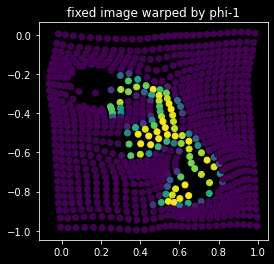

In [209]:
N = 56
N = 100
plt.style.use("dark_background")
l = 0
a = l * iden + (1 - l) * phi
plt.title("fixed image warped by phi-1")
plt.axes().set_aspect('equal')
plt.scatter(a[N][1].flatten(), -a[N][0].flatten(), 
            c=fixed_image[N, 0].cpu().numpy().flatten())

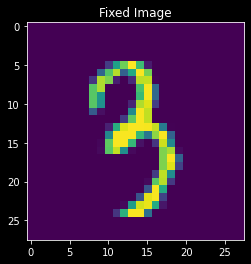

In [210]:
plt.title("Fixed Image")
plt.imshow(fixed_image[N, 0].cpu().numpy())

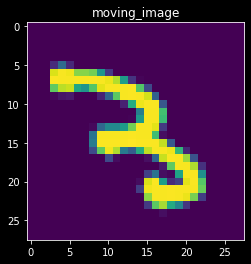

In [211]:
plt.title("moving_image")
plt.imshow(moving_image[N, 0].cpu().numpy())

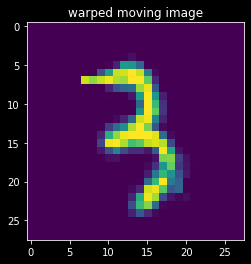

In [212]:
plt.title("warped moving image")
plt.imshow(net.warped_moving_image[N, 0].detach().cpu())

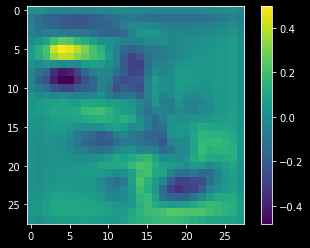

In [213]:
plt.imshow(net.mermaid_unit.m[N, 0].cpu().detach())
plt.colorbar()

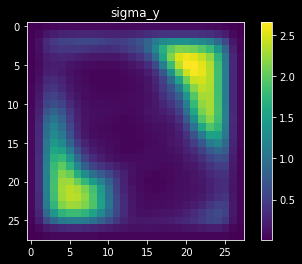

In [214]:
plt.title("sigma_y")
plt.imshow(torch.exp(net.log_Sigma).detach().cpu().numpy()[N][0])
plt.colorbar()

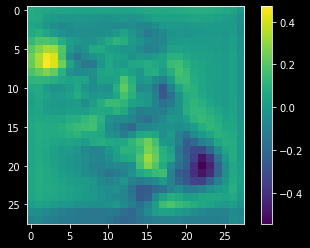

In [215]:
plt.imshow(net.mu.detach().cpu().numpy()[N][1])
plt.colorbar()

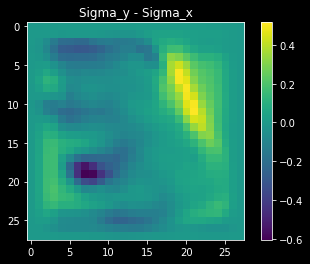

In [216]:


c_sigma = torch.exp(net.log_Sigma).detach().cpu().numpy()[N]
plt.title("Sigma_y - Sigma_x")
plt.imshow(c_sigma[0] - c_sigma[1])
plt.colorbar()

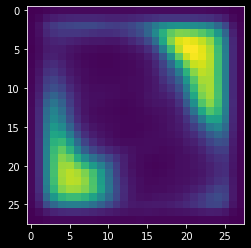

In [217]:
plt.imshow(c_sigma[0])

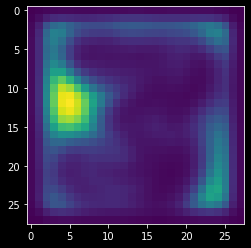

In [200]:
plt.imshow(c_sigma[1])